### 라이브러리 불러오기

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# 데이터 불러오기
df = pd.read_csv('./data/Womens Clothing E-Commerce Reviews.csv')

# 데이터 살펴보기
df.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [5]:
# 데이터 개수
len(df)

23486

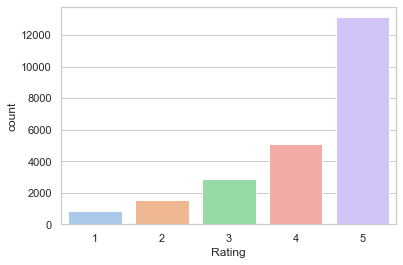

In [6]:
# 그래프 테마 설정
sns.set_theme(style="whitegrid", palette="pastel")
# 점수 분포
sns.countplot(data=df, x="Rating")
plt.show()

In [7]:
# 리뷰 글자수
df['Review Text'].dropna().map(len)

0         53
1        303
2        500
3        124
4        192
        ... 
23481    131
23482    223
23483    208
23484    427
23485    110
Name: Review Text, Length: 22641, dtype: int64

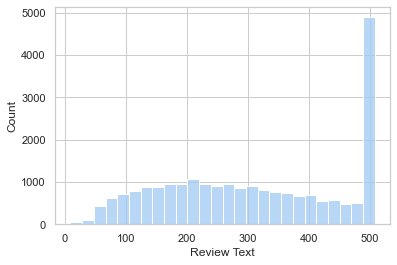

In [8]:
# 리뷰 길이 분포 (글자수)
sns.histplot(df['Review Text'].dropna().map(len))
plt.show()

In [9]:
# 가장 긴 리뷰의 글자수
df['Review Text'].dropna().map(len).max()

508

In [10]:
# 리뷰 단어수
df['Review Text'].dropna().map(lambda x: len(x.split()))

0         8
1        62
2        98
3        22
4        36
         ..
23481    28
23482    38
23483    42
23484    86
23485    19
Name: Review Text, Length: 22641, dtype: int64

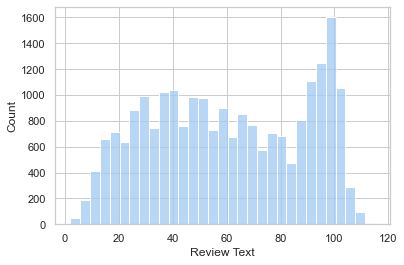

In [11]:
# 리뷰 길이 분포 (단어수)
sns.histplot(df['Review Text'].dropna().map(lambda x: len(x.split())))
plt.show()

In [12]:
# 가장 긴 리뷰의 단어수
df['Review Text'].dropna().map(lambda x: len(x.split())).max()

115

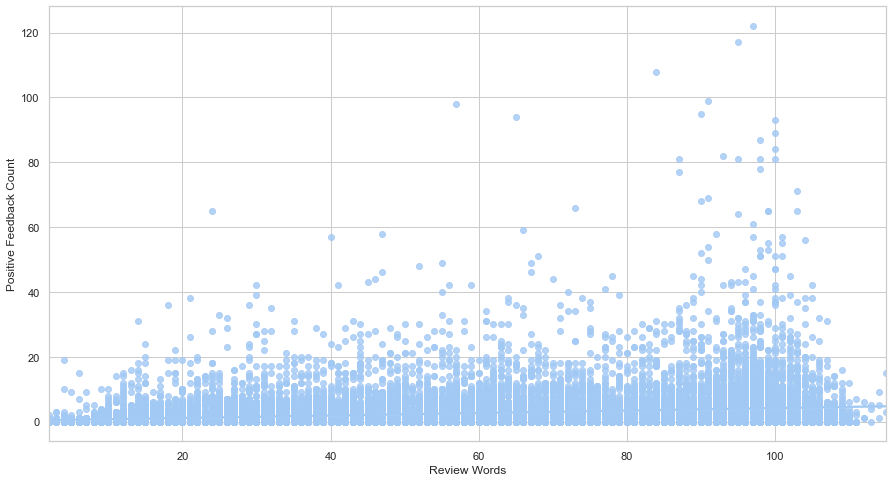

In [13]:
# 리뷰 길이와 리뷰 투표수
df["Review Words"] = df['Review Text'].dropna().map(lambda x: len(x.split()))
g = sns.regplot(x="Review Words", y="Positive Feedback Count", data=df)
g.figure.set_size_inches(15, 8)
plt.show()

In [14]:
df_clean = df.dropna(subset=['Review Text']).copy()

In [15]:
# 점수 분포에서 5점이 압도적으로 많기 때문에, 5점을 positive, 4점 이하를 negative로 둔다.
df_clean['Label'] = df_clean['Rating'] == 5

### 텍스트 전처리

In [16]:
import spacy
from collections import Counter
import math
from tqdm import tqdm

In [17]:
# 필요한 리소스를 로드해야 한다. 영어 리소스 로드.
nlp = spacy.load("en_core_web_sm")

In [18]:
tokens_normalized = []
for doc in tqdm(nlp.pipe(df_clean['Review Text'].str.lower())):
  lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
  tokens_normalized.append(lemmas)

22641it [02:40, 141.16it/s]


**Phrase modeling (bigram & trigram)**

In [19]:
from gensim.models.phrases import Phrases, Phraser

In [20]:
# gensim을 이용해서 phrase modeling을 한다
bigram_model = Phrases(tokens_normalized)
bigram_phraser = Phraser(bigram_model)

In [21]:
tokens_bigram = []
for s in tokens_normalized:
    bigram_phrases = bigram_phraser[s]
    tokens_bigram.append(bigram_phrases)

In [22]:
trigram_model = Phrases(tokens_bigram)
trigram_phraser = Phraser(trigram_model)

In [23]:
tokens_trigram = []
for s in tokens_bigram:
    trigram_phrases = trigram_phraser[s]
    trigram_phrases = [token for token in trigram_phrases if token not in nlp.Defaults.stop_words and token != '-PRON-']
    tokens_trigram.append(trigram_phrases)

In [24]:
preprocessed_sentences = []
for s in tokens_trigram:
  preprocessed_sentences.append(' '.join(s))

In [25]:
df_clean['Reviews Preprocessed'] = preprocessed_sentences

#### 학습용 데이터와 테스트용 데이터 나누기

In [26]:
from sklearn.model_selection import train_test_split
# scikit-learn의 train_test_split에서 학습용 데이터와 테스트용 데이터의 디폴트 비율은 75:25이다.
df_train, df_test = train_test_split(df_clean, random_state=0)

In [27]:
def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    bigrams = bigram_phraser[lemmas]
    trigrams = trigram_phraser[bigrams]
    tokens_normalized = [lemma for lemma in trigrams if lemma not in nlp.Defaults.stop_words and lemma != '-PRON-']
    return tokens_normalized

### 사전으로 하는 감성분석

- 감성어 사전을 만들고 이를 이용해 감성 분석 정확도를 구해보자
- 출처 : https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt

In [28]:
# 긍정 단어는 1, 부정 단어는 -1로 표기한다.
sentiment_vocab = {
 'adorable': 1,
 'adore': 1,
 'allow': 1,
 'amazing': 1,
 'appreciate': 1,
 'attractive': 1,
 'avoid': -1,
 'awesome': 1,
 'awful': -1,
 'awkward': -1,
 'bad': -1,
 'beautiful': 1,
 'beautifully': 1,
 'beauty': 1,
 'best': 1,
 'better': 1,
 'bother': -1,
 'bright': 1,
 'bummer': -1,
 'care': 1,
 'careful': 1,
 'casual': 1,
 'certainly': 1,
 'chance': 1,
 'chic': 1,
 'classy': 1,
 'comfort': 1,
 'comfortable': 1,
 'comfortably': 1,
 'compliment': 1,
 'cool': 1,
 'crazy': -1,
 'create': 1,
 'cut': -1,
 'cute': 1,
 'definitely': 1,
 'difficult': -1,
 'disappoint': -1,
 'disappointed': -1,
 'disappointing': -1,
 'disappointment': -1,
 'dream': 1,
 'easily': 1,
 'easy': 1,
 'elegant': 1,
 'enjoy': 1,
 'excellent': 1,
 'excited': 1,
 'expose': -1,
 'fabulous': 1,
 'fantastic': 1,
 'favorite': 1,
 'feeling': 1,
 'fine': 1,
 'fit': 1,
 'flattering': 1,
 'flirty': 1,
 'forgiving': 1,
 'friend': 1,
 'fun': 1,
 'generous': 1,
 'glad': 1,
 'good': 1,
 'gorgeous': 1,
 'great': 1,
 'hand': 1,
 'happy': 1,
 'hate': -1,
 'help': 1,
 'hesitant': -1,
 'hesitate': -1,
 'hide': -1,
 'holiday': 1,
 'honestly': 1,
 'hope': 1,
 'hopefully': 1,
 'hug': 1,
 'huge': 1,
 'interesting': 1,
 'itchy': -1,
 'justice': 1,
 'lack': -1,
 'like': 1,
 'loose': -1,
 'lose': -1,
 'love': 1,
 'lovely': 1,
 'low': -1,
 'miss': -1,
 'nice': 1,
 'nicely': 1,
 'odd': -1,
 'ok': 1,
 'okay': 1,
 'party': 1,
 'perfect': 1,
 'perfection': 1,
 'perfectly': 1,
 'pleased': 1,
 'pretty': 1,
 'problem': -1,
 'recommend': 1,
 'regret': -1,
 'relaxed': 1,
 'rich': 1,
 'ridiculous': -1,
 'romantic': 1,
 'ruin': -1,
 'sad': -1,
 'sadly': -1,
 'seriously': -1,
 'sexy': 1,
 'solid': 1,
 'special': 1,
 'stop': -1,
 'straight': 1,
 'strange': -1,
 'stunning': 1,
 'substantial': 1,
 'super': 1,
 'support': 1,
 'sure': 1,
 'surprise': 1,
 'surprised': 1,
 'surprisingly': 1,
 'sweet': 1,
 'terrible': -1,
 'thank': 1,
 'thrill': 1,
 'trouble': -1,
 'true': 1,
 'truly': 1,
 'uncomfortable': -1,
 'unfortunately': -1,
 'vibrant': 1,
 'warm': 1,
 'waste': -1,
 'weird': -1,
 'winner': 1,
 'wish': 1,
 'wonderful': 1,
 'wonderfully': 1,
 'worried': -1,
 'worry': -1,
 'worth': 1,
 'wow': 1,
 'wrong': -1,
 'yes': 1}

In [29]:
# 텍스트를 받아 점수를 반환하는 예측 함수를 만든다.
def predict_with_dictionary(normalized_text):
    tokens = normalized_text.split()
    review_score = 0
    for token in tokens:
      token_score = sentiment_vocab.get(token, 0)
      review_score = review_score + token_score
    review_score = review_score/len(tokens)
    pred = review_score > 0
    return pred

In [30]:
# 정답과 예측
predictions_with_dict = df_test['Reviews Preprocessed'].map(predict_with_dictionary)

In [31]:
# 정확도 (accuracy) 구하기
corrects_with_dict = df_test['Label'] == predictions_with_dict
corrects_with_dict.sum() / len(corrects_with_dict)

## 사전으로 하는 감성분석은 정확도가 약 58% 정도 나왔다

0.5804628157569334

### 토픽으로 하는 감성분석

- 문서의 토픽을 추출하여 긍부정을 예측

In [32]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaMulticore

In [33]:
dictionary = Dictionary(tokens_trigram)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()

In [34]:
def make_bow_corpus(tokens):
    """
    generator function to read in reviews from the file
    and output a bag-of-words represention of the text
    """
    for review in tokens:
        yield dictionary.doc2bow(review)

corpus_filepath = 'corpus.mm'
MmCorpus.serialize(corpus_filepath, make_bow_corpus(tokens_trigram))
review_corpus = MmCorpus(corpus_filepath)

In [35]:
# warnings.filterwarnings("ignore", category=DeprecationWarning)
lda = LdaMulticore(review_corpus,
                    num_topics=10,
                    id2word=dictionary,
                    workers=2,
                    random_state=13)

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [37]:
ldavis = pyLDAvis.gensim_models.prepare(topic_model=lda, 
                                     corpus=review_corpus, 
                                     dictionary=dictionary)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
pyLDAvis.display(ldavis)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# 참고: 안타깝게도 gensim과 pyLDAvis는 동일한 토픽 인덱스를 공유하지 않는다. 
# 아래에 현재 토픽 모델에서 두 인덱스가 어떻게 매핑되는지 적어놓았다.
# gensim index -> pyLDAvis index
#  0 -> 7
#  1 -> 8
#  2 -> 6
#  3 -> 9
#  4 -> 4
#  5 -> 10
#  6 -> 5
#  7 -> 3
#  8 -> 1
#  9 -> 2

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
lda.show_topic(0)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('fit', 0.031453937),
 ('love', 0.02597497),
 ('size', 0.024052786),
 ('order', 0.023599742),
 ('wear', 0.023358291),
 ('small', 0.018375931),
 ('look', 0.01473023),
 ('great', 0.0147180855),
 ('color', 0.011048195),
 ('dress', 0.0109260995)]

In [41]:
# 토픽 마다 이름을 정해주고 긍부정을 표기해보자.
topic_sentiments = {0: ('fit', 1),
               1: ('leggings & jeans', 0),
               2: ('waist fit', -1),
               3: ('skirt & blouse', 0),
               4: ('nice color', 1),
               5: ('great', 1),
               6: ('fabric', -1),
               7: ('special occasion', 1),
               8: ('size problem', -1),
               9: ('love', 1),
              }

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# 리뷰와 LDA 결과를 눈으로 보자
# warnings.filterwarnings("ignore", category=DeprecationWarning)
def describe_review_from_raw(text, min_frequency=0.1):
    tokens = preprocess_text(text)
    normalized_text = ' '.join(tokens)
    review_lda = get_lda(normalized_text)
    sentiment = get_sentiment(normalized_text)

    for topic, frequency in sorted(review_lda, key=lambda x: x[1], reverse=True):

        if frequency < min_frequency: continue
        print('{:25} {}'.format(topic_sentiments[topic][0], round(frequency, 3)))

    print()
    
    print("positiveness : {}".format(sentiment))

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# LDA로 긍부정을 예측하는 함수를 만든다.
def get_lda(normalized_text):
    tokens = normalized_text.split()
    bow = dictionary.doc2bow(tokens)
    lda_result = lda[bow]
    return lda_result

def get_sentiment(normalized_text):
    review_lda = get_lda(normalized_text)
    sentiments = [(topic_sentiments[topic][1] * frequency, frequency) for topic, frequency in review_lda 
                  if topic_sentiments[topic][1] != 0]
    if not sentiments:
        return 0
    else:
        return sum(senti for senti, freq in sentiments) / sum(freq for senti, freq in sentiments)

def predict_with_lda(normalized_text):
    sentiment = get_sentiment(normalized_text)
    return sentiment >= 0

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
text = df_train['Review Text'].iloc[0]
print(text)
print()
describe_review_from_raw(text)

I love this shirt, i had my eye on it for awhile but wasn't sure what size i'd be, so i went to the store to try. they only had a small which i figured i would be but it was a little large and not as fitted as i would like it across the chest. i got an xs and it was perfect; i am 5'1 about 120 lbs and a small c cup and it fits great. i love it!!

waist fit                 0.5130000114440918
fit                       0.24799999594688416
love                      0.210999995470047

positiveness : -0.0805756248242249


C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# 정답과 예측
predictions_with_lda = df_test['Reviews Preprocessed'].map(predict_with_lda)

# 정확도 (accuracy) 구하기
corrects_with_lda = df_test['Label'] == predictions_with_lda
corrects_with_lda.sum() / len(corrects_with_lda)

## 토픽으로 하는 감성분석은 약 55% 의 정확도를 보인다

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5573220279102632

### 통계로 하는 감성분석

- 로지스틱 회귀를 이용해 텍스트 분류

In [46]:
# vectorizer를 초기화하기
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# 사전(vocabulary) 학습하기. document-term matrix를 만드는 데 사용됨
vect.fit(df_train['Reviews Preprocessed'])
X_train_dtm = vect.transform(df_train['Reviews Preprocessed'])

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# 테스트 데이터를 document-term matrix로 바꾸기 (학습된 사전 활용)
X_test_dtm = vect.transform(df_test['Reviews Preprocessed'])
X_test_dtm

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<5661x11513 sparse matrix of type '<class 'numpy.int64'>'
	with 117067 stored elements in Compressed Sparse Row format>

In [49]:
# logistic regression model을 불러오고 초기화
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# X_train_dtm를 이용해 모델 학습
logreg.fit(X_train_dtm, df_train['Label'])

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LogisticRegression(max_iter=1000)

In [51]:
# X_test_dtm에 대해 클래스 예측
y_pred_class = logreg.predict(X_test_dtm)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# X_test_dtm에 대해 확률 예측
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.78184701, 0.3541867 , 0.06452221, ..., 0.01852732, 0.91959515,
       0.97169527])

In [53]:
print(df_test['Review Text'].iloc[0])
print()
print(y_pred_prob[0])

Beautiful and very versatile dress. extremely forgiving for post baby bodies, while stylish and classy.

0.7818470073784249


C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# 클래스 예측 정확도 구하기
accuracy_score(df_test['Label'], y_pred_class)

## 통계로 하는 감성분석은 약 77%의 정확도를 보인다

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7705352411234764

### 딥러닝으로 하는 감성분석

- 미리 학습된 딥러닝 모델을 불러와 파인튜닝(fine-tuning)을 통해 텍스트 분류를 해보자

In [56]:
# 토크나이저를 불러온다.
from transformers import AutoTokenizer
# 이 실습에서는 BERT의 다국어 버전 base 모델을 사용할 것이다. 다국어 버전에는 한국어도 지원한다.
# cased라는 말은 소문자로 normalized 되지 않았다는 뜻이다.
# large 모델도 존재하며, base보다 모델 크기가 크고 정확도가 더 높다.
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# 시험 삼아 무작위의 글을 토크나이징 해보자
# 토크나이징 결과로 만들어진 단어 인덱스의 리스트가 input_ids에 담긴다.
print(df_train['Review Text'].loc[0])
tokenizer(df_train['Review Text'].loc[0], padding="max_length", truncation=True)

Absolutely wonderful - silky and sexy and comfortable


C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'input_ids': [101, 108394, 10454, 11367, 11304, 14446, 118, 33694, 11445, 10111, 18549, 10157, 10111, 10212, 81587, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
# 토크나이징을 여러번 반복하기 쉽게 함수로 만든다.
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# datasets 라이브러리를 불러온다.
# 허깅페이스에서 개발한 자연어 등 여러 데이터셋을 다루기 위한 라이브러리이다.
from datasets import Dataset

# 리뷰 텍스트와 레이블로 데이터셋을 만든다.
dataset_train = Dataset.from_dict({'text': df_train['Review Text'], 'label': df_train['Label']})
dataset_test = Dataset.from_dict({'text': df_test['Review Text'], 'label': df_test['Label']})

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# dataset의 map 함수를 이용해 토크나이징 함수를 적용한다.
dataset_train_tokenized = dataset_train.map(tokenize_function, batched=True)
dataset_test_tokenized = dataset_test.map(tokenize_function, batched=True)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [61]:
# 모델을 불러온다.
# 분류용으로 불러오며, 분류하는 레이블은 2개이다.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [62]:
# 모델을 학습시키는 인자(arguments)를 정의하는 클래스이다.
# 데이터셋 전체를 한번 학습하는 것을 epoch이라 하며, 보통 여러 epoch을 돌며 모델을 학습시킨다.
# 이 실습에서는 빠른 결과를 보기 위해 1 epoch만 학습한다.
from transformers import TrainingArguments

training_args = TrainingArguments("runs", num_train_epochs=1)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# 정확도를 계산하기 위한 함수를 정의한다.

import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
# 모델을 학습시키는 Trainer 클래스를 정의한다.
# 모델과 데이터셋, 정확도 측정 함수가 들어간다.

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_tokenized,
    eval_dataset=dataset_test_tokenized,
    compute_metrics=compute_metrics,
)

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# 학습을 진행한다.
# GPU 서버에서 1 epoch을 학습하면 약 1시간이 걸린다.
trainer.train()

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# 학습이 끝난 모델을 평가한다.
# 약 80%의 정확도를 기록하는 것을 볼 수 있다.
trainer.evaluate()

C:\Users\82104\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
